In [1]:
import os
import re
import string
import numpy as np
import gensim 
from itertools import chain
from string import punctuation
from os import listdir
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D,GRU, Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import flair
import nltk.data
from sklearn.metrics import accuracy_score
PATH_TO_DATA="data/aclImdb"
PATH_TO_GLOVE_100="data/glove/glove.6B.100d.txt"
PATH_TO_GLOVE_300="data/glove/glove.6B.300d.txt"
VOCAB_SIZE=5000
REVIEW_MAX_LEN=500

In [2]:
def load_file(filename):
    with open(filename, 'r', encoding="utf8") as file:
        text = file.read()
    return text

def preprocess(review):
    review = review.lower()
    regx = re.compile('<[^<>]+>')
    review = regx.sub(repl=' ', string=review)
    regx = re.compile(r"(http|https)://[^\s]*")
    review, nhttps = regx.subn(repl="", string=review)
    regx = re.compile(r"\b[^\s]+@[^\s]+[.][^\s]+\b")
    review, nemails = regx.subn(repl="", string=review)
    regx = re.compile(r"[\d.]+")
    review = regx.sub(repl="", string=review)
    regx = re.compile(r"([^\w\s]+)|([_-]+)")  
    review = regx.sub(repl=" ", string=review)
    regx = re.compile(r"\n\n")
    review = regx.sub(repl=" ", string=review)
    regx = re.compile(r"\n")
    review = regx.sub(repl=" ", string=review)
    regx = re.compile(r"\s+")
    review = regx.sub(repl=" ", string=review)
    tokens = review.split()
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    stemmer = SnowballStemmer("english")
    stemwords = [stemmer.stem(wd) for wd in tokens]
    return " ".join(stemwords)

def add_review_to_vocab(review_fname, vocab):
    review = load_file(review_fname)
    tokens = preprocess(review)
    vocab.update(tokens)
 
def process_reviews(directory, vocab):
    for filename in listdir(directory):
        path = directory + '/' + filename
        add_review_to_vocab(path, vocab)

In [3]:
vocab = Counter()
reviews_processed_train=[]
y_train=[]
for sentiment in ["pos", "neg"]:
    for fname in listdir(f"{PATH_TO_DATA}/train/{sentiment}"):
        review=preprocess(load_file(f"{PATH_TO_DATA}/train/{sentiment}/{fname}"))
        reviews_processed_train.append(review)
        vocab.update(review.split(" "))
        y_train.append(1 if sentiment=="pos" else 0)
y_train = np.array(y_train)
reviews_processed_test=[]
y_test=[]
for sentiment in ["pos", "neg"]:
    for fname in listdir(f"{PATH_TO_DATA}/test/{sentiment}"):
        review=preprocess(load_file(f"{PATH_TO_DATA}/test/{sentiment}/{fname}"))
        reviews_processed_test.append(review)
        vocab.update(review.split(" "))
        y_test.append(1 if sentiment=="pos" else 0)
y_test = np.array(y_test)
print(vocab.most_common(20))

[('movi', 102716), ('film', 95564), ('one', 55259), ('like', 45116), ('time', 31806), ('good', 30072), ('make', 30013), ('charact', 28288), ('see', 28183), ('get', 27945), ('watch', 27787), ('even', 25296), ('stori', 25222), ('would', 24596), ('realli', 23060), ('well', 21421), ('scene', 21398), ('look', 19912), ('show', 19858), ('bad', 19730)]


In [4]:
def transform_reviews(reviews_train, reviews_test, vocab_size=5000, skip_top=0,
              start_char=1, oov_char=2, index_from=3):
    vocab = Counter()
    for review in chain(reviews_train, reviews_test):
        vocab.update(review.split(" "))
    vocab_entries_idxies={
        word_info[0]: idx for idx, word_info in enumerate(vocab.most_common(vocab_size))
    }
    reviews_numerized = []
    for review in chain(reviews_train, reviews_test):
        review_numerized=[]
        for word in review.split(" "):
            if oov_char:
                if not word in vocab_entries_idxies or vocab_entries_idxies[word]<skip_top:
                    review_numerized.append(oov_char)
                else:
                    review_numerized.append(vocab_entries_idxies[word])
            else:
                 if word in vocab_entries_idxies and vocab_entries_idxies[word]>skip_top:
                    review_numerized.append(vocab_entries_idxies[word])
        reviews_numerized.append(review_numerized)
    x_train = np.array([np.array(review) for review in reviews_numerized[:len(reviews_train)]])
    x_test = np.array([np.array(review) for review in reviews_numerized[len(reviews_train):]])
    return x_train, x_test, vocab_entries_idxies

In [5]:
X_train, X_test, vocab_indexes=transform_reviews(reviews_processed_train, reviews_processed_test, vocab_size=VOCAB_SIZE)

In [6]:
X_train = sequence.pad_sequences(X_train, maxlen=REVIEW_MAX_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=REVIEW_MAX_LEN)

In [7]:
def plot_history(history):
    plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
    plt.subplot(211)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.subplot(212)
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

In [8]:
def create_and_evaluate_model(embedding_layer, max_epochs=20, lstm_units=64):
    model=Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)]
    model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])
    history=model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=max_epochs, callbacks=callbacks, shuffle=True)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    return loss, accuracy, history

In [9]:
embedding_size=128

In [12]:
embedding_size=128
loss, accuracy, history=create_and_evaluate_model(Embedding(VOCAB_SIZE, embedding_size, input_length=REVIEW_MAX_LEN))
print(f"Model loss={loss}, accuracy={accuracy}")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 771,713
Trainable params: 771,713
Non-trainable params: 0
_________________________________________________________________
None
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 710s 35ms/sample - loss: 0.4567 - accuracy: 0.7897 - val_loss: 1.5710 - val_accuracy: 0.3274
Epoch 2/20
20000/20000 [==============================] - 757s 38ms/sample - loss: 0.3502 - accuracy: 0.8565 - val_loss: 0.4462 - val_accuracy: 0.7538
Epoch 3/20
20000/20000

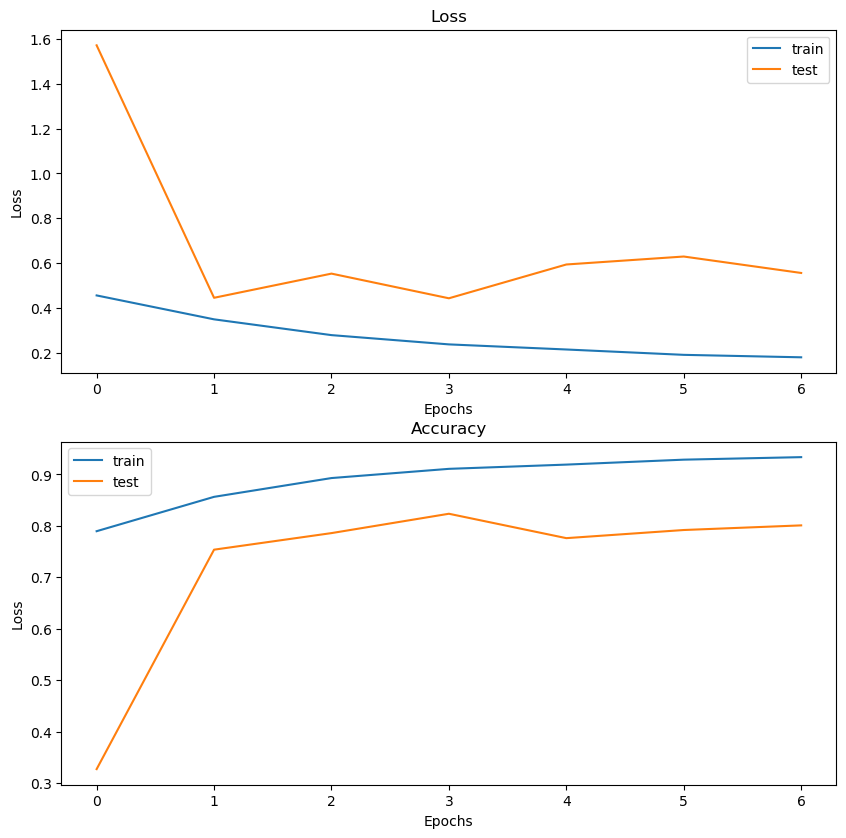

In [13]:
plot_history(history)

In [10]:
def get_glove_embedding_matrix(path_to_glove, glove_size, vocab_indexes):
    embeddings_index = {}
    with open(path_to_glove, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    embedding_matrix = np.zeros((VOCAB_SIZE, glove_size))
    for word, i in vocab_indexes.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [15]:
embedding_matrix_100=get_glove_embedding_matrix(PATH_TO_GLOVE_100, 100, vocab_indexes)

In [16]:
loss, accuracy, history=create_and_evaluate_model(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix_100], input_length=REVIEW_MAX_LEN, trainable=False))
print(f"Model loss={loss}, accuracy={accuracy}")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          500000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 617,377
Trainable params: 117,377
Non-trainable params: 500,000
_________________________________________________________________
None
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 661s 33ms/sample - loss: 0.5819 - accuracy: 0.6928 - val_loss: 0.7409 - val_accuracy: 0.6206
Epoch 2/20
20000/20000 [==============================] - 685s 34ms/sample - loss: 0.5181 - accuracy: 0.7516 - val_loss: 0.7885 - val_accuracy: 0.5982
Epoch 3/20
20000

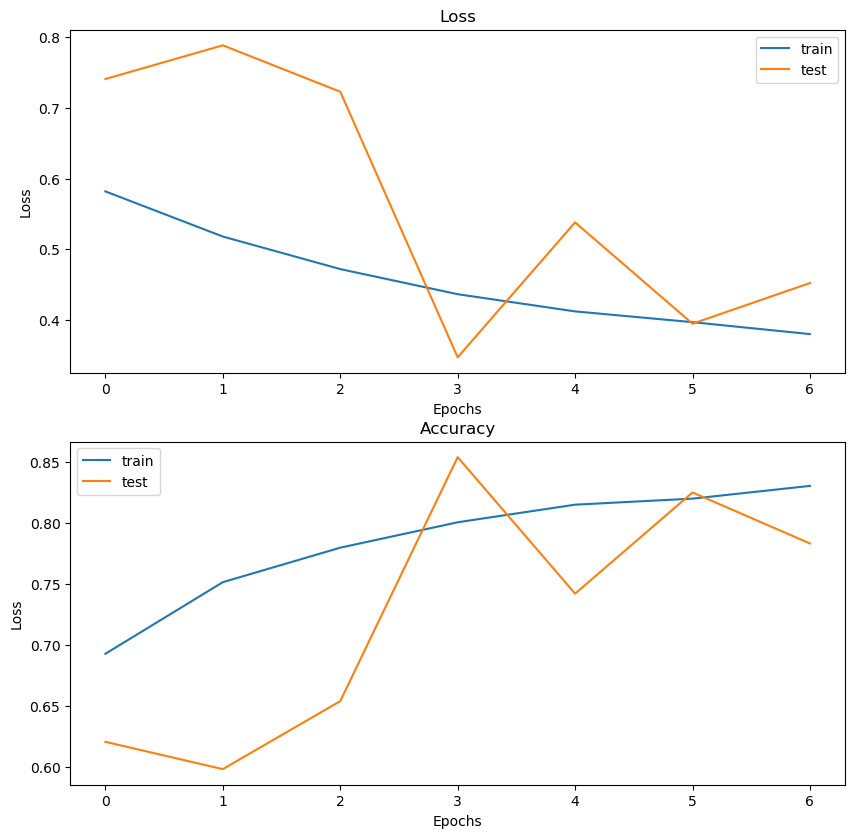

In [17]:
plot_history(history)

In [11]:
embedding_matrix_300=get_glove_embedding_matrix(PATH_TO_GLOVE_300, 300, vocab_indexes)

In [12]:
loss, accuracy, history=create_and_evaluate_model(Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix_300], input_length=REVIEW_MAX_LEN, trainable=False))
print(f"Model loss={loss}, accuracy={accuracy}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,719,777
Trainable params: 219,777
Non-trainable params: 1,500,000
_________________________________________________________________
None
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 977s 49ms/sample - loss: 0.5276 - accuracy: 0.7419 - val_loss: 0.7196 - val_accuracy: 0.6316
Epoch 2/20
20000/20000 [==============================] - 1139s 57ms/sample - loss: 0.4504 - accuracy: 0.7983 - val_loss: 0.4824 - val_accuracy: 0.7568
Epoch 3/20
20

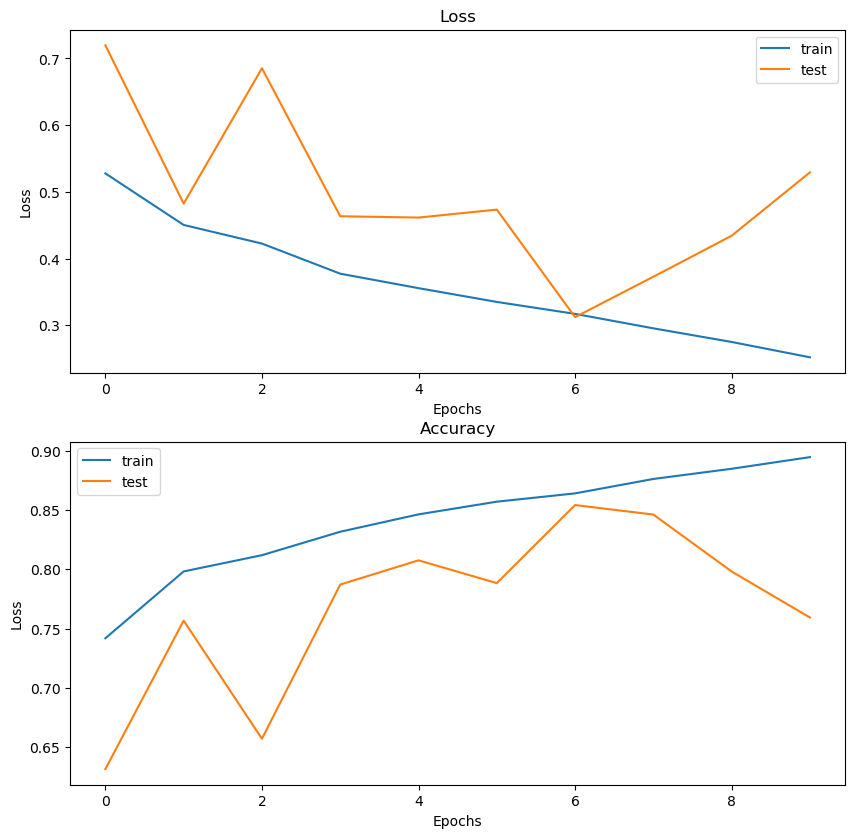

In [13]:
plot_history(history)

In [19]:
w2v_size=300
w2v_model = gensim.models.Word2Vec(
        [review.split(" ") for review in chain(reviews_processed_train, reviews_processed_test)],
        size=w2v_size,
        min_count=5)

In [20]:
def get_w2v_embedding_matrix(w2v_model, vocab_indexes, w2v_size):
    embedding_matrix = np.zeros((VOCAB_SIZE, w2v_size))
    for word, i in vocab_indexes.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
    return embedding_matrix

In [21]:
embedding_matrix_w2v=get_w2v_embedding_matrix(w2v_model, vocab_indexes, w2v_size)
loss, accuracy, history=create_and_evaluate_model(Embedding(VOCAB_SIZE, w2v_size, weights=[embedding_matrix_w2v], input_length=REVIEW_MAX_LEN, trainable=False))
print(f"Model loss={loss}, accuracy={accuracy}")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 300)          1500000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,719,777
Trainable params: 219,777
Non-trainable params: 1,500,000
_________________________________________________________________
None
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 1032s 52ms/sample - loss: 0.4479 - accuracy: 0.7947 - val_loss: 0.3569 - val_accuracy: 0.8488
Epoch 2/20
20000/20000 [==============================] - 1061s 53ms/sample - loss: 0.3572 - accuracy: 0.8450 - val_loss: 0.6095 - val_accuracy: 0.7166
Epoch 3/20

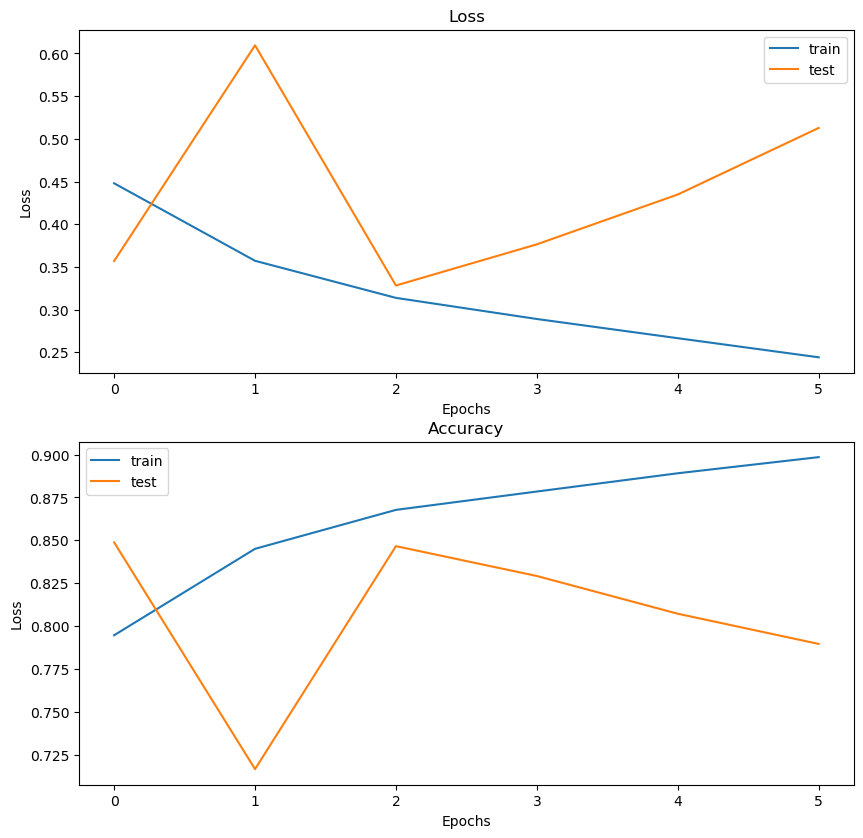

In [22]:
plot_history(history)

In [23]:
def evaluate_model(model, max_epochs=20):
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)]
    model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])
    history=model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=max_epochs, callbacks=callbacks, shuffle=True)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    return loss, accuracy, history

In [25]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, w2v_size, weights=[embedding_matrix_w2v], input_length=REVIEW_MAX_LEN, trainable=False))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
loss, accuracy, history=evaluate_model(model)
print(f"Model loss={loss}, accuracy={accuracy}")

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 1132s 57ms/sample - loss: 0.4792 - accuracy: 0.7767 - val_loss: 0.3922 - val_accuracy: 0.8278
Epoch 2/20
20000/20000 [==============================] - 1084s 54ms/sample - loss: 0.3857 - accuracy: 0.8374 - val_loss: 0.5930 - val_accuracy: 0.7222
Epoch 3/20
20000/20000 [==============================] - 1099s 55ms/sample - loss: 0.3810 - accuracy: 0.8377 - val_loss: 0.4923 - val_accuracy: 0.7808
Epoch 4/20
20000/20000 [==============================] - 1090s 55ms/sample - loss: 0.3441 - accuracy: 0.8555 - val_loss: 0.3441 - val_accuracy: 0.8658
Epoch 5/20
20000/20000 [==============================] - 1068s 53ms/sample - loss: 0.3283 - accuracy: 0.8634 - val_loss: 0.3870 - val_accuracy: 0.8368
Epoch 6/20
20000/20000 [==============================] - 1069s 53ms/sample - loss: 0.3298 - accuracy: 0.8618 - val_loss: 0.3552 - val_accuracy: 0.8586
Epoch 7/20
25000/25000 [===============

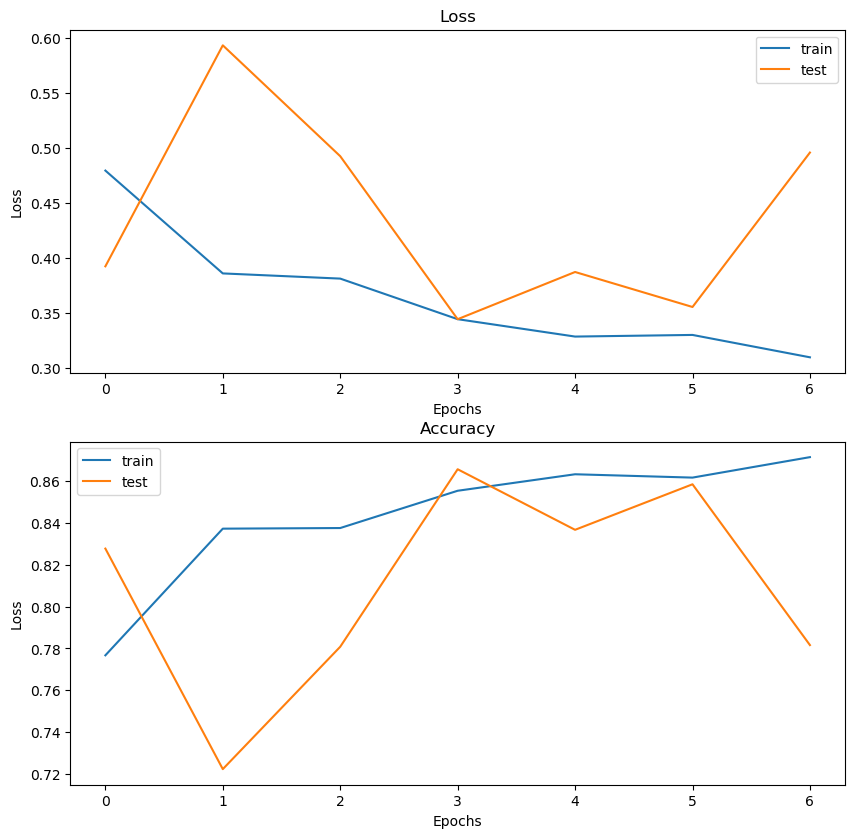

In [26]:
plot_history(history)

In [27]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, w2v_size, weights=[embedding_matrix_w2v], input_length=REVIEW_MAX_LEN, trainable=False))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
loss, accuracy, history=evaluate_model(model)
print(f"Model loss={loss}, accuracy={accuracy}")

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 1198s 60ms/sample - loss: 0.4662 - accuracy: 0.7799 - val_loss: 0.3269 - val_accuracy: 0.8630
Epoch 2/20
20000/20000 [==============================] - 1203s 60ms/sample - loss: 0.3253 - accuracy: 0.8608 - val_loss: 0.2834 - val_accuracy: 0.8858
Epoch 3/20
20000/20000 [==============================] - 1201s 60ms/sample - loss: 0.2897 - accuracy: 0.8789 - val_loss: 0.3211 - val_accuracy: 0.8646
Epoch 4/20
20000/20000 [==============================] - 1205s 60ms/sample - loss: 0.2685 - accuracy: 0.8890 - val_loss: 0.2548 - val_accuracy: 0.8976
Epoch 5/20
20000/20000 [==============================] - 1189s 59ms/sample - loss: 0.2490 - accuracy: 0.8979 - val_loss: 0.3934 - val_accuracy: 0.8326
Epoch 6/20
20000/20000 [==============================] - 1186s 59ms/sample - loss: 0.2291 - accuracy: 0.9075 - val_loss: 0.3437 - val_accuracy: 0.8682
Epoch 7/20
25000/25000 [===============

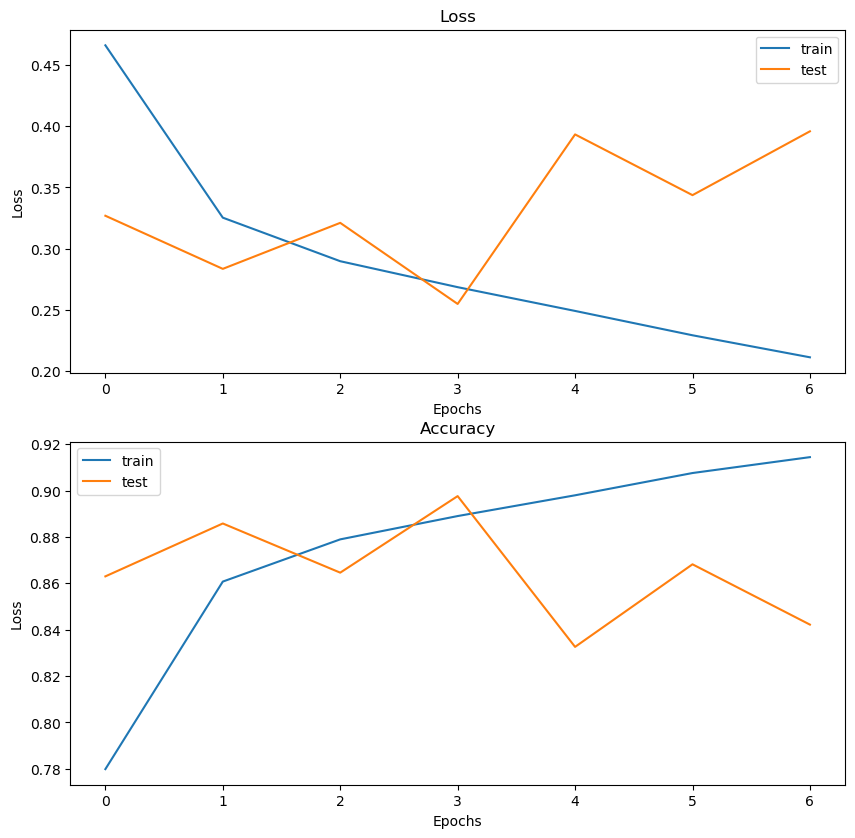

In [28]:
plot_history(history)

In [29]:
model = Sequential()
model.add(Dense(256, activation='relu',input_dim=REVIEW_MAX_LEN))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
loss, accuracy, history=evaluate_model(model)
print(f"Model loss={loss}, accuracy={accuracy}")

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 110us/sample - loss: 28.2441 - accuracy: 0.5293 - val_loss: 2.0577 - val_accuracy: 0.0750
Epoch 2/20
20000/20000 [==============================] - 2s 93us/sample - loss: 1.5481 - accuracy: 0.5527 - val_loss: 0.7270 - val_accuracy: 0.1440
Epoch 3/20
20000/20000 [==============================] - 2s 94us/sample - loss: 0.7826 - accuracy: 0.5935 - val_loss: 0.7948 - val_accuracy: 0.0000e+00
Epoch 4/20
20000/20000 [==============================] - 2s 89us/sample - loss: 0.7122 - accuracy: 0.6135 - val_loss: 0.8403 - val_accuracy: 0.0000e+00
Epoch 5/20
25000/25000 [==============================] - 1s 41us/sample - loss: 0.6949 - accuracy: 0.4943
Model loss=0.6948993331336976, accuracy=0.49432000517845154


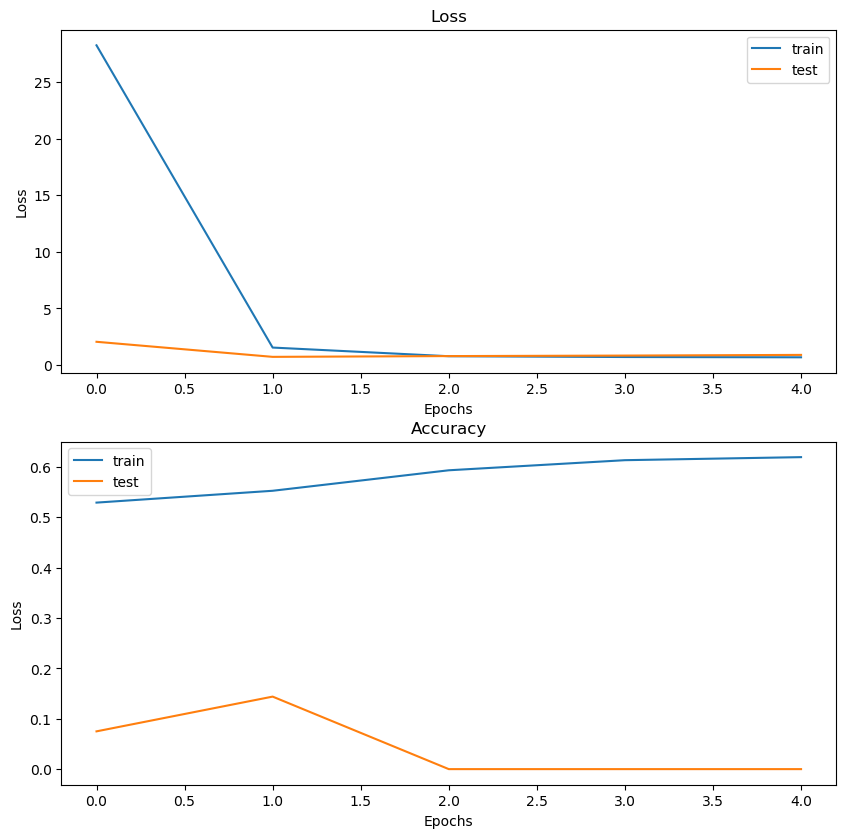

In [30]:
plot_history(history)

In [32]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, embedding_size, input_length=REVIEW_MAX_LEN))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
loss, accuracy, history=evaluate_model(model)
print(f"Model loss={loss}, accuracy={accuracy}")

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 58s 3ms/sample - loss: 0.4819 - accuracy: 0.7531 - val_loss: 0.6445 - val_accuracy: 0.7040
Epoch 2/20
20000/20000 [==============================] - 57s 3ms/sample - loss: 0.1956 - accuracy: 0.9305 - val_loss: 0.6194 - val_accuracy: 0.7694
Epoch 3/20
20000/20000 [==============================] - 59s 3ms/sample - loss: 0.0366 - accuracy: 0.9886 - val_loss: 0.8407 - val_accuracy: 0.7718
Epoch 4/20
20000/20000 [==============================] - 58s 3ms/sample - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.8802 - val_accuracy: 0.8134
Epoch 5/20
25000/25000 [==============================] - 43s 2ms/sample - loss: 0.4066 - accuracy: 0.8470
Model loss=0.40663138671636584, accuracy=0.847000002861023


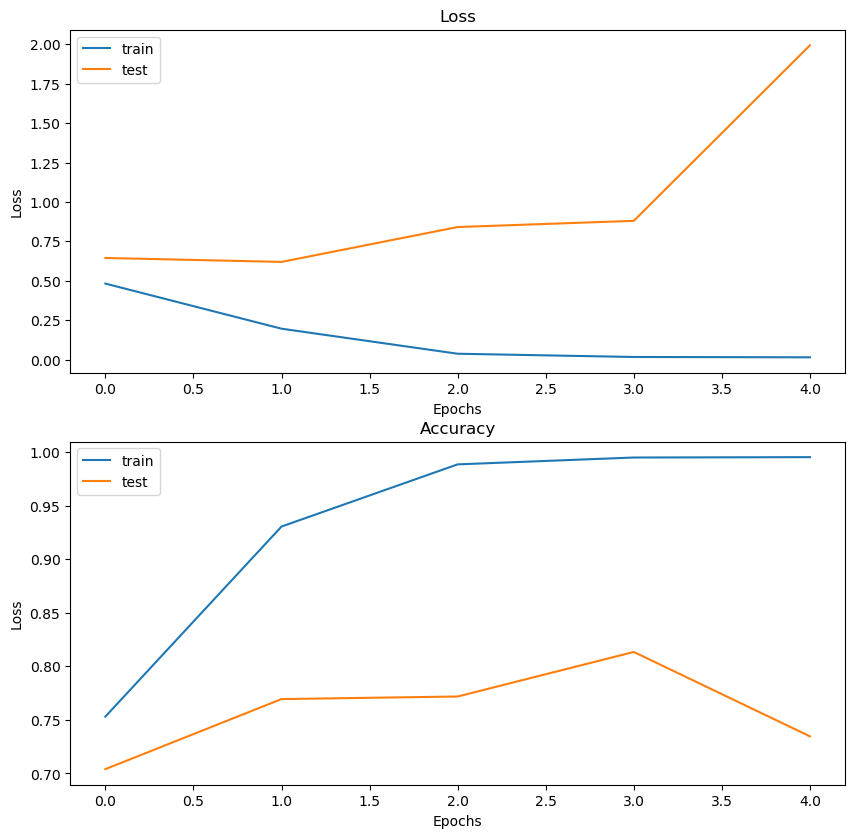

In [33]:
plot_history(history)

In [34]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, w2v_size, weights=[embedding_matrix_w2v], input_length=REVIEW_MAX_LEN, trainable=False))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
loss, accuracy, history=evaluate_model(model)
print(f"Model loss={loss}, accuracy={accuracy}")

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 179s 9ms/sample - loss: 0.4678 - accuracy: 0.7775 - val_loss: 0.7023 - val_accuracy: 0.6566
Epoch 2/20
20000/20000 [==============================] - 179s 9ms/sample - loss: 0.3537 - accuracy: 0.8475 - val_loss: 0.3223 - val_accuracy: 0.8694
Epoch 3/20
20000/20000 [==============================] - 179s 9ms/sample - loss: 0.3041 - accuracy: 0.8727 - val_loss: 0.5933 - val_accuracy: 0.7500
Epoch 4/20
20000/20000 [==============================] - 182s 9ms/sample - loss: 0.2481 - accuracy: 0.8986 - val_loss: 0.3726 - val_accuracy: 0.8616
Epoch 5/20
25000/25000 [==============================] - 95s 4ms/sample - loss: 0.3758 - accuracy: 0.8304
Model loss=0.3758173867225647, accuracy=0.8303999900817871


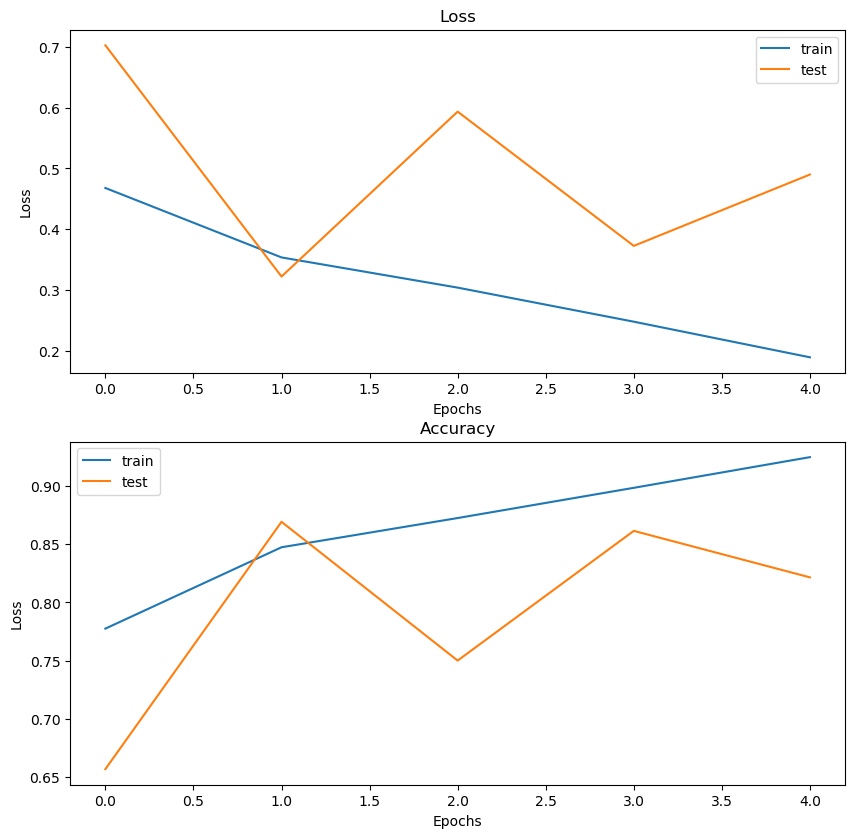

In [35]:
plot_history(history)

In [36]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, w2v_size, weights=[embedding_matrix_w2v], input_length=REVIEW_MAX_LEN, trainable=False))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
loss, accuracy, history=evaluate_model(model)
print(f"Model loss={loss}, accuracy={accuracy}")

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 497s 25ms/sample - loss: 0.4000 - accuracy: 0.8152 - val_loss: 0.3242 - val_accuracy: 0.8556
Epoch 2/20
20000/20000 [==============================] - 490s 24ms/sample - loss: 0.2972 - accuracy: 0.8745 - val_loss: 0.3361 - val_accuracy: 0.8552
Epoch 3/20
20000/20000 [==============================] - 494s 25ms/sample - loss: 0.2524 - accuracy: 0.8949 - val_loss: 0.2620 - val_accuracy: 0.8864
Epoch 4/20
20000/20000 [==============================] - 504s 25ms/sample - loss: 0.2124 - accuracy: 0.9157 - val_loss: 0.5906 - val_accuracy: 0.7562
Epoch 5/20
20000/20000 [==============================] - 495s 25ms/sample - loss: 0.1752 - accuracy: 0.9304 - val_loss: 0.5200 - val_accuracy: 0.8262
Epoch 6/20
25000/25000 [==============================] - 118s 5ms/sample - loss: 0.2868 - accuracy: 0.8790
Model loss=0.2868489451217651, accuracy=0.8789600133895874


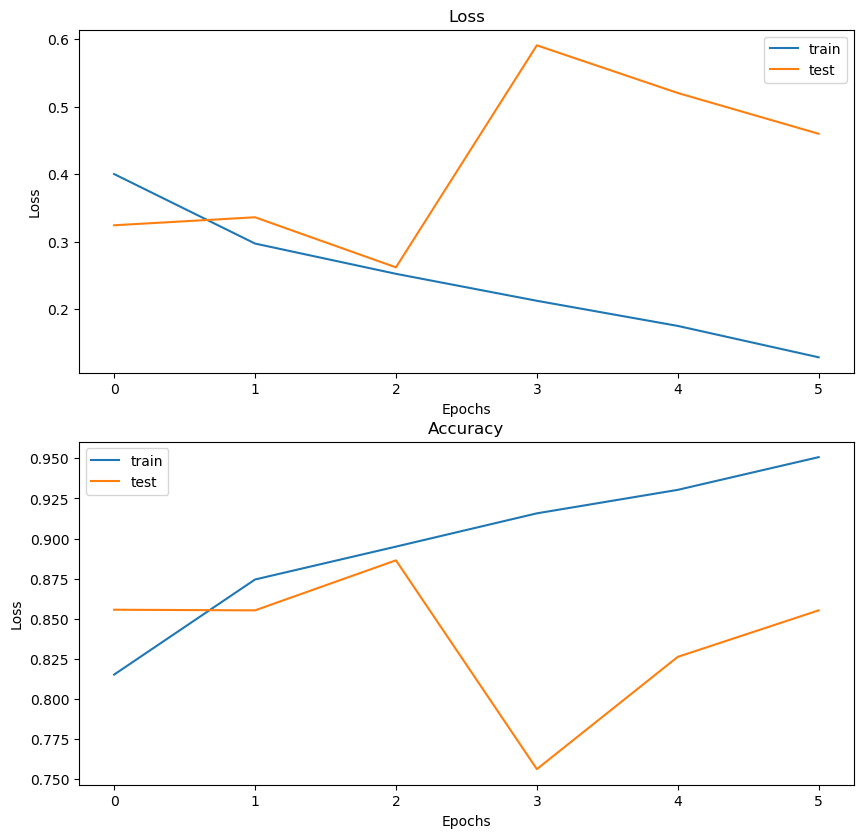

In [37]:
plot_history(history)

In [22]:
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2020-05-04 20:58:32,776 loading file C:\Users\Mikita_Ivanin\.flair\models\imdb-v0.4.pt


In [24]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
y_true=[]
y_pred=[]
sentences=[]
sentence_to_review_map={}
for sentiment in ["pos", "neg"]:
    files_list=listdir(f"{PATH_TO_DATA}/test/{sentiment}")[:2500]
    for fname in files_list:
        review=load_file(f"{PATH_TO_DATA}/test/{sentiment}/{fname}")
        for sentence in tokenizer.tokenize(review):
            sentence_to_review_map[len(sentences)]=len(y_true)
            sentences.append(sentence)
        y_true.append(1 if sentiment=="pos" else 0)
result=flair_sentiment.predict(sentences, verbose=True)
pos_sum=0
neg_sum=0
for res_idx, res_sentence in enumerate(result):
    if res_idx>0 and sentence_to_review_map[res_idx-1]!=sentence_to_review_map[res_idx]:
        if pos_sum>neg_sum:
            y_pred.append(1)
        else:
            y_pred.append(0)
        pos_sum=0
        neg_sum=0
    for label in res_sentence.labels:
        if label.value=="POSITIVE":
            pos_sum+=label.score
        elif label.value=="NEGATIVE":
            neg_sum+=label.score
        else:
            raise ValueError(f"Unexpected label {label.value}")
if pos_sum>neg_sum:
    y_pred.append(1)
else:
    y_pred.append(0)

Inferencing on batch 1630: 100%|███████████████████████████████████████████████████████| 1631/1631 [56:57<00:00,  2.10s/it]


In [25]:
print(f"Flair accuracy score: {accuracy_score(y_true, y_pred)}")

Flair accuracy score: 0.7746
